In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")

import os
import sys; sys.path.append('../')
import numpy as np
from numpy.random import default_rng
from numpy.fft import fft, ifft
from findiff import FinDiff

import scipy.io as sio
import pysindy as ps
from PDE_FIND import build_linear_system, print_pde, TrainSTRidge
from robust_PDE_FIND import RobustPCA
from best_subset import *
from UBIC import *

from sklearn.decomposition import PCA, TruncatedSVD
# from skimage.restoration import denoise_wavelet, estimate_sigma

from pydmd import DMD, BOPDMD
from pydmd.plotter import plot_eigs, plot_summary, plot_modes_2D
from pydmd.preprocessing.hankel import hankel_preprocessing

def evaluate_coefficients(prediected_coeffs):
    GROUND = np.array([0.1, -1])
    errs = 100*np.abs(GROUND-np.array(prediected_coeffs).flatten())/np.abs(GROUND)
    return errs.mean(), errs.std()

Sklearn's version: 1.2.2


#### Load data

In [2]:
data = sio.loadmat('../Datasets/burgers.mat')
u = (data['usol']).real
x = (data['x'][0]).real
t = (data['t'][:,0]).real
dt = t[1]-t[0]
dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

#### Visualization

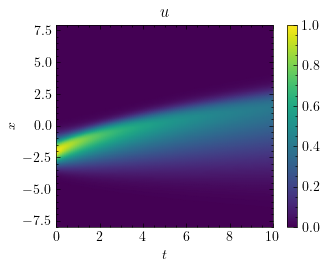

In [3]:
with plt.style.context(['science']):
    ufig, uax = plt.subplots()
    contour = uax.pcolormesh(t, x, u, shading='gouraud')
    uax.set_xlabel("$t$")
    uax.set_ylabel("$x$")
    uax.set_title("$u$")
    cbar = ufig.colorbar(contour)
    # ufig.savefig("../Figures/burgers.png", dpi=300)
    plt.show()

#### Add noise

In [4]:
print("----- Clean -----")
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=False)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(np.expand_dims(u, -1), t=dt)
model.print()

Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
rhs_des = rhs_des[1:]
R = R[:, 1:].real; Ut = Ut.real
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

print()

print("----- Add 30% noise -----")
np.random.seed(0)
noise_lv = float(30)
print(noise_lv)
noise = 0.01*np.abs(noise_lv)*(u.std())*np.random.randn(u.shape[0],u.shape[1])
un = u + noise
np.mean(noise), np.std(noise), np.max(noise), np.min(noise)

Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=3, time_diff = 'poly',
                                       deg_x = 4, deg_t = 4, 
                                       width_x = 10, width_t = 10)
rhs_des = rhs_des[1:]
Rn = Rn[:, 1:].real; Utn = Utn.real
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

----- Clean -----
STLSQ model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
l0_penalty: 1.6123253173828125
PDE derived using STRidge
u_t = (-1.000403 +0.000000i)uu_{x}
    + (0.100145 +0.000000i)u_{xx}
   

----- Add 30% noise -----
30.0
l0_penalty: 1.93969921875
PDE derived using STRidge
u_t = (-0.775461 +0.000000i)uu_{x}
   


In [5]:
print(np.linalg.norm(u-un, ord='fro'), np.linalg.norm(u-un, ord=np.inf))

8.673577639876537 5.298318588581592


#### Use the precomputed denoised variable given by the K-SVD

In [6]:
denoised = True
if denoised: 
    denoised_un = np.load("../Examples/denoised_files/burgers_dictlearn_denoised30_components32_8x8.npy")
    un = denoised_un
    
    ### PCA ###
#     target_percentage = 99.5
#     summ = 0.0
#     n_components = 0
#     sigma = PCA(n_components=un.shape[-1]).fit(un).explained_variance_ratio_
#     for s in sigma:
#         summ += s
#         n_components += 1
#         if summ > target_percentage/100:
#             break
#     print(n_components, summ)
#     assert n_components < len(sigma)
#     pca = PCA(n_components=un.shape[-1]).fit(un)
#     pca_un = pca.inverse_transform(pca.transform(un))
#     un = pca_un
    
    ### SVD ###
#     target_percentage = 99.5
#     summ = 0.0
#     n_components = 0
#     U, Sigma, V = np.linalg.svd(un, full_matrices=False); V = V.T
#     sigma = Sigma/sum(Sigma)
#     for s in sigma:
#         summ += s
#         n_components += 1
#         if summ > target_percentage/100:
#             break
#     print(n_components, summ)
#     assert n_components < len(Sigma)
#     svd_un = U[:, 0:n_components].dot(np.diag(Sigma[0:n_components]).dot(V[:,0:n_components].T))
#     un = svd_un
    
    ### Wavelet denoising ###
#     wavelet_un = denoise_wavelet(un, channel_axis=None, convert2ycbcr=False, 
#                                  sigma=estimate_sigma(un, channel_axis=None, average_sigmas=True), 
#                                  method='BayesShrink', mode='soft', rescale_sigma=True)
#     un = wavelet_un
    
    ### Robust PCA ###
#     rpca_lam = 0.1
#     un, _ = RobustPCA(un, rpca_lam)
    
    ### FFT ###    
#     def remove_f(uu, percent):
#         if percent <= 0: return uu
#         PSD = (uu*np.conj(uu))/np.prod(uu.shape)
#         PSD = PSD.real
#         mask = (PSD>np.percentile(PSD, percent)).astype(np.float32)
#         return uu*mask
#     remove_percent = 50
#     un = ifft(remove_f(fft(un), remove_percent)).real
    
    print(np.linalg.norm(u-un, ord='fro'), np.linalg.norm(u-un, ord=np.inf))

2.858361587460368 2.274811883362282


#### Applying DMD

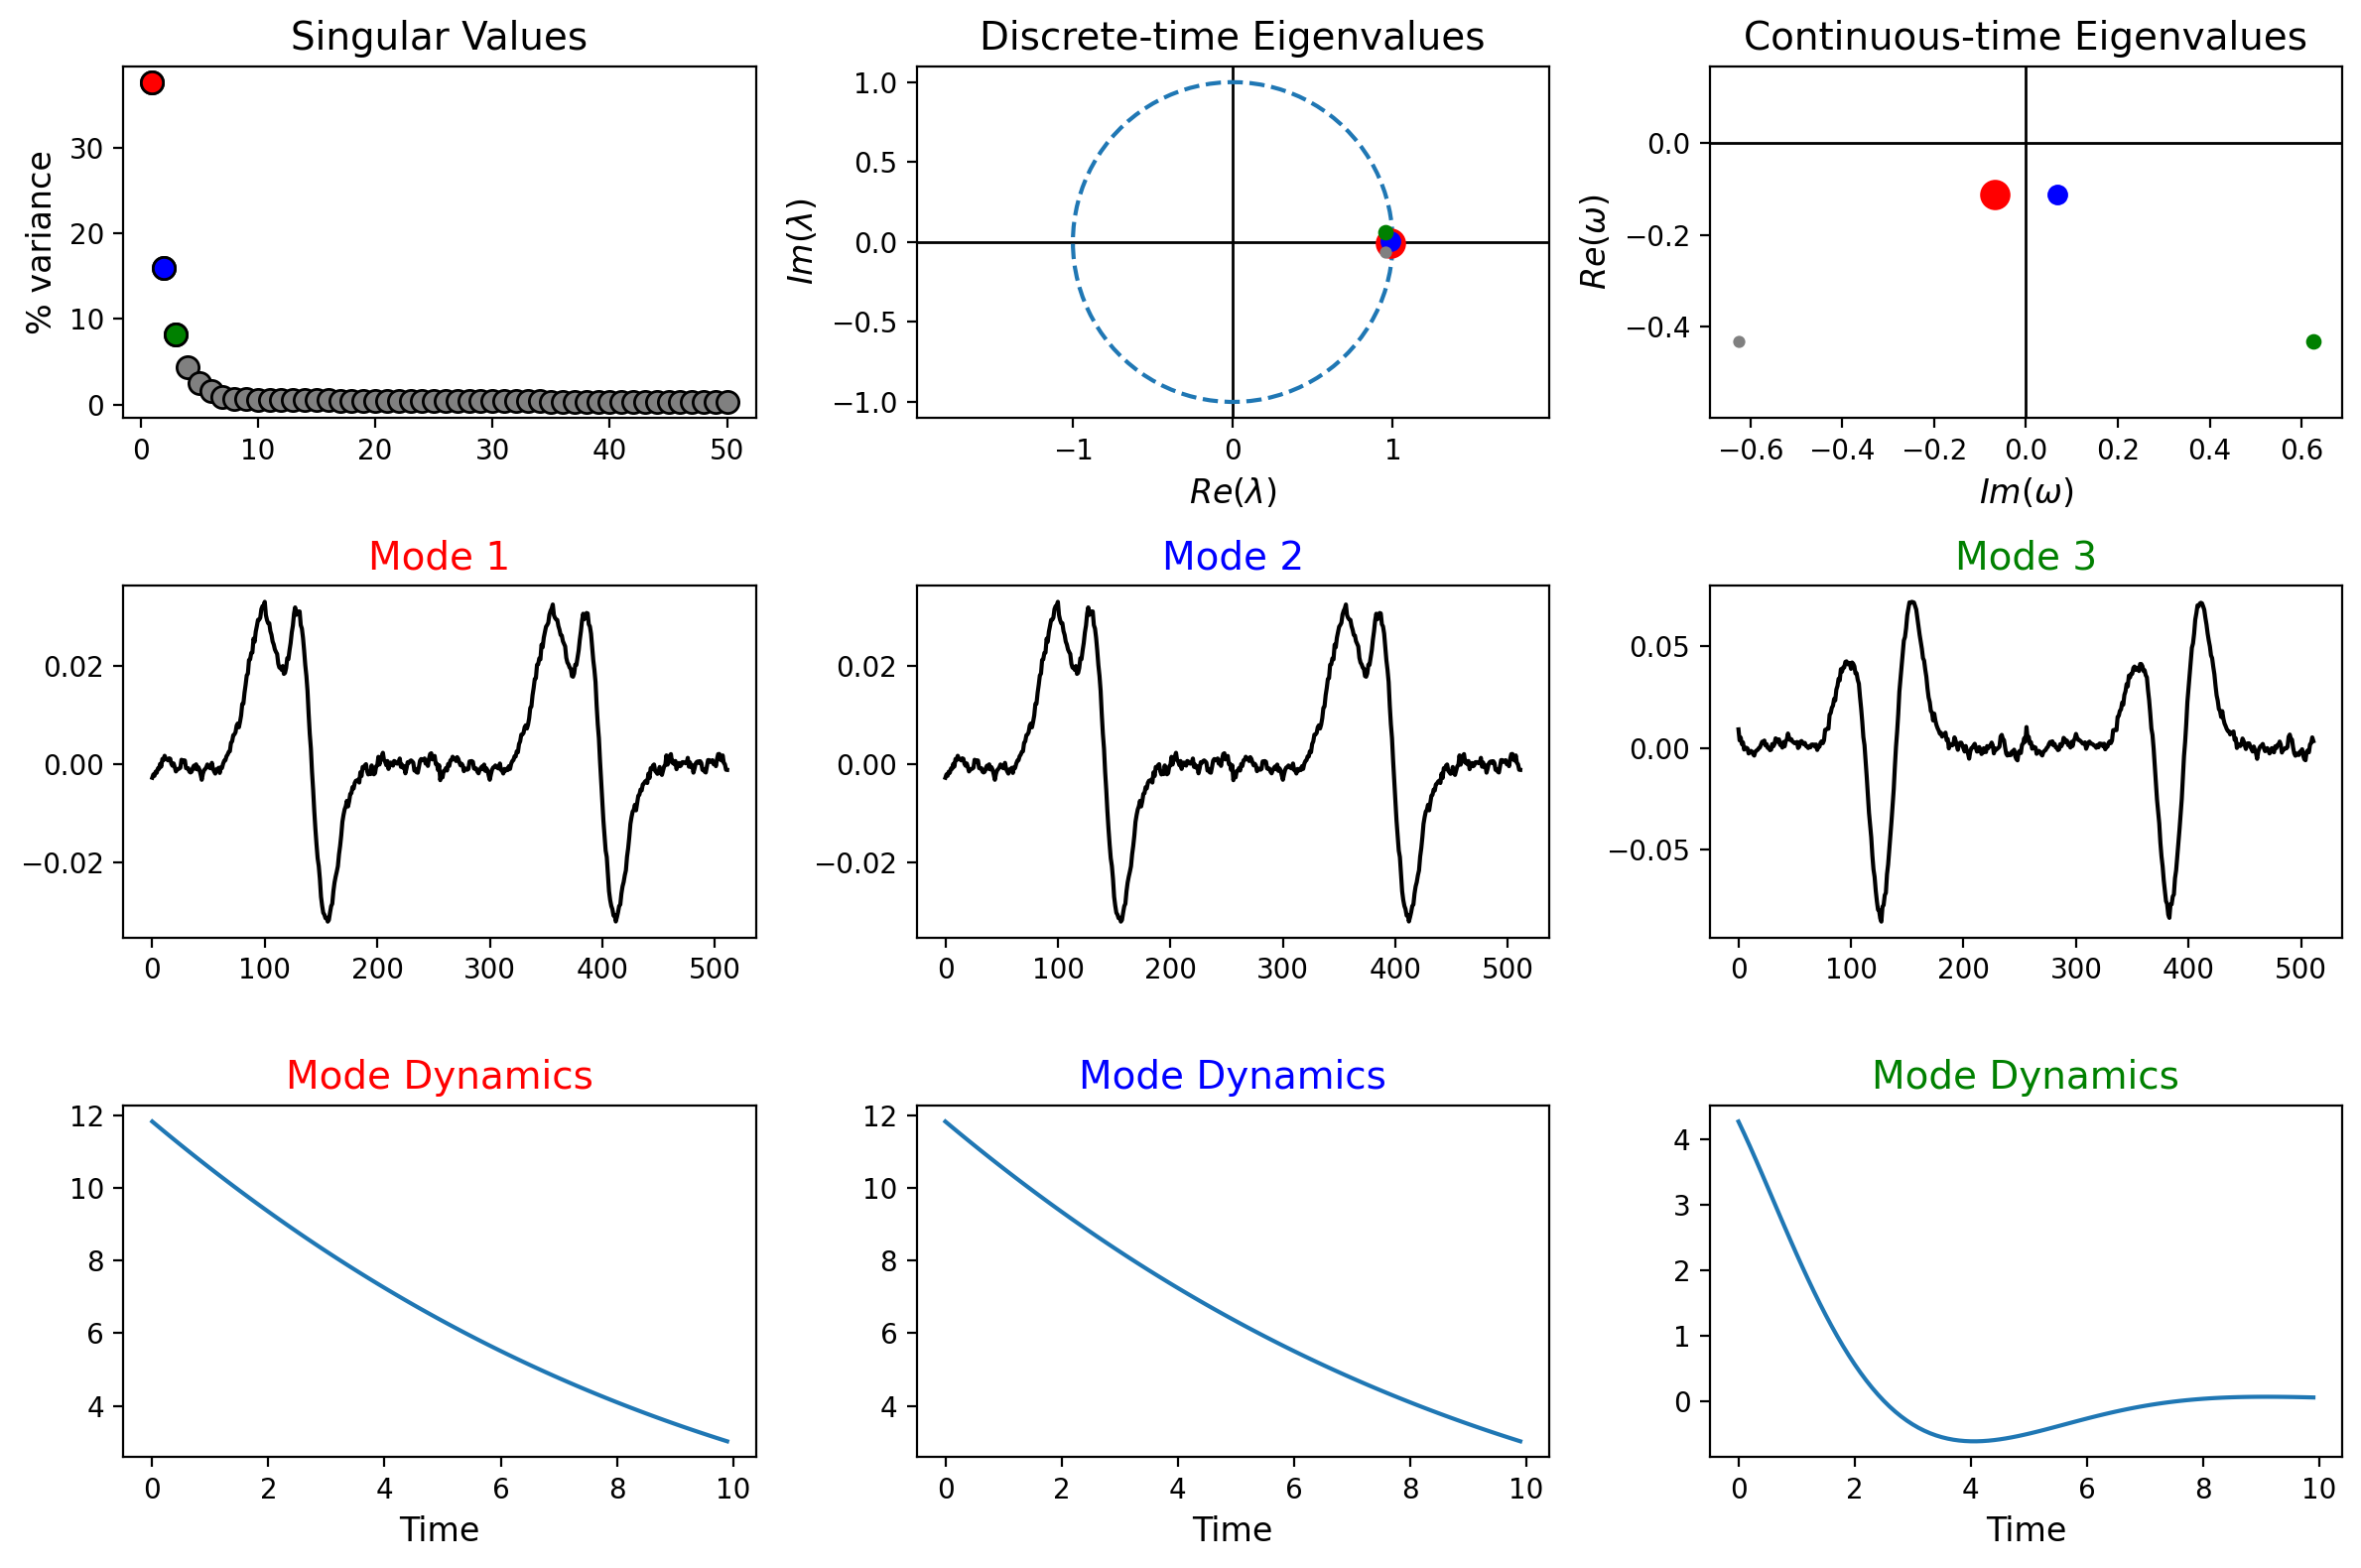

Frequencies (imaginary component): [-0.432-0.626j -0.113-0.068j -0.113+0.068j -0.432+0.626j]


In [7]:
# Build the Optimized DMD model.
# num_trials=0 gives Optimized DMD, without bagging.
# major components / major components + 1 -> choose one that produce recon_un close to un?
# might not be optimal for every noise intensity
dmd_algos = "BOPDMD" # "BOPDMD"
varpro_opts_dict = {"tol":3/4, "verbose":False}
delays = 2
if dmd_algos == "DMD":
    optdmd = DMD(svd_rank=4, tlsq_rank=0, exact=True, opt=True)
    delay_optdmd = hankel_preprocessing(optdmd, d=delays) # Wrap the model with the preprocessing routine.
    delay_optdmd.fit(un)
elif dmd_algos == "BOPDMD":
    # Note: BOPDMD models need the data X and the times of data collection t for fitting.
    # Hence if we apply time-delay, we must adjust the length of our time vector accordingly.
    optdmd = BOPDMD(svd_rank=4, num_trials=100, 
                    varpro_opts_dict=varpro_opts_dict)
    delay_optdmd = hankel_preprocessing(optdmd, d=delays) # Wrap the model with the preprocessing routine.
    num_t = len(t)-delays+1
    delay_optdmd.fit(un, t=t[:num_t])

# # Plot a summary of the DMD results.
plot_summary(optdmd)

# Print computed eigenvalues (frequencies are given by imaginary components).
# Also plot the resulting data reconstruction.
print(
    f"Frequencies (imaginary component): {np.round(delay_optdmd.eigs, decimals=3)}"
)

time_scales = (0.8, 1) # (0.8, 0.9, 1)x(1, 1.5, 2)
# not for BOPDMD
dmd_dt = dt
if dmd_algos == "DMD":
    optdmd.dmd_time["dt"] *= time_scales[0]
    optdmd.dmd_time["tend"] *= time_scales[1]
    dmd_dt = optdmd.dmd_timesteps*dt
    dmd_dt = dmd_dt[1]-dmd_dt[0]
    
un = delay_optdmd.reconstructed_data.real

#### Applying best-subset regression on the weak formulation

In [8]:
poly_deg = None; diff_order = 2
differentiation_method = ps.FiniteDifference; differentiation_kwargs = {}
kwargs = {'copy_X':True, 'normalize_columns':False}

weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
                                 function_names=[lambda x: x, lambda x: x + x], 
                                 derivative_order=diff_order, p=diff_order, 
                                 spatiotemporal_grid=XT, 
                                 include_bias=False, is_uniform=True, K=10000, # new random K points in every calls to the ps.WeakPDELibrary
                                 cache=True
                                )

X_pre, y_pre, fns = ps_features(un, dmd_dt, weak_pde_lib, kwargs)

differentiation method or differentiation_kwargs is not implemented in feature_library.


In [9]:
optimizer_name = "miosr" # "l0bnb", "miosr"
assert (optimizer_name == "l0bnb") or (optimizer_name == "miosr")
if optimizer_name == "l0bnb":
    optimizer = L0BNB(max_nonzeros=2, lam=1e-3, is_normal=True, normalize_columns=False)
elif optimizer_name == "miosr":
    optimizer = ps.MIOSR(target_sparsity=2, normalize_columns=True, regression_timeout=100)
    
n_ensemble_models = 50
model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                 differentiation_method=differentiation_method,
                 cache=True,
                 feature_names=['u'])
model.fit(np.expand_dims(un, -1), t=dmd_dt)

# print found pde
print_pde(model.get_coef_list()[np.argmin(np.sum((np.squeeze(np.tensordot(X_pre, np.array(model.get_coef_list()).T, axes=([-1], [0])), axis=1)-y_pre)**2, axis=0))].reshape(-1,1), model.get_feature_names())

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04
u_t = (0.120705 +0.000000i)u_11
    + (-0.810992 +0.000000i)uu_1
   


In [10]:
best_subsets = [tuple(np.where(abs(brute_force(X_pre, y_pre, support_size=i).flatten())>0)[0]) 
                for i in range(1, X_pre.shape[1]+1)]

#### Model selection by the UBIC (Algorithm 1)

In [11]:
tau = 3
verbose = True
scale = np.log(len(y_pre))
# scale = 1 <- generalized UBIC
per = 75 # 75, 85, 95

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means

b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], y_pre))-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    if verbose:
        print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
              np.nan_to_num(imp, nan=np.inf))
    
    if (diff_com > 0 and (diff_bic > 0 or imp <= thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp >= thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 10)
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1
    
last_lam = round(last_lam, 10)
last_lam, last_ubic, last_bc, best_bc

threshold: 0.005282070139714268
max_lam: 3.9023683019014244
1 <---> 1 inf
1 <---> 1 inf
1 <---> 5 0.00228024063139762


(1.300789434,
 array([-62077.07748144, -73376.27822545, -73111.17822584, -73090.48599006,
        -72748.55053469, -72716.06376268, -72397.43579791, -71450.05938698]),
 1,
 1)

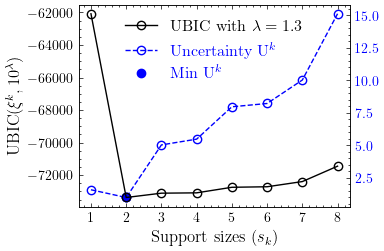

In [12]:
complexity_axis = [len(bs) for bs in best_subsets]
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)
    
    l1, = ax.plot(complexity_axis, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(last_lam)}$")
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{UBIC}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
#     ax.annotate('$(u_{xx}, uu_{x})\checkmark$', fontsize=16, 
#                  xy=(complexity_axis[best_bc], last_ubic[best_bc]), 
#                  xytext=(complexity_axis[best_bc]+0.1, last_ubic[best_bc]+4000), 
#                  arrowprops={'arrowstyle': '->'})
    
    l2, = ax2.plot(complexity_axis, b_uns, 'o--', c='blue', markerfacecolor='none', label="Uncertainty $\\textrm{U}^{k}$")
    s1 = ax2.scatter(complexity_axis[np.argmin(b_uns)], b_uns[np.argmin(b_uns)], c='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax.legend([l1, l2, s1], [f"UBIC with $\lambda = {abs(round(last_lam, 2))}$", "Uncertainty $\\textrm{U}^{k}$", "Min $\\textrm{U}^{k}$"], 
              labelcolor='linecolor', loc='upper center', fontsize=11.5)
    
    # plt.savefig("burgers_wavelet_ubic.pdf")
    plt.show()

#### Percent coefficient error

In [13]:
evaluate_coefficients(np.linalg.lstsq(X_pre[:, best_subsets[best_bc]], 
                                      y_pre, rcond=None)[0].flatten())

(20.128821427130035, 2.091053285149398)

In [14]:
# No denoising: 8.673577639876537 5.298318588581592 
# rksvd: 2.858361587460368 2.274811883362282 | (0.9107969701290103, 0.3772757947444888)
# svd n_comp=74: 8.2830942877307 4.990897588534944 | (0.4377375780166351, 0.18439574973366096)
# svd n_comp=86: 8.51040101515912 5.163254362785331 | (0.5747929503770288, 0.03141691852627804)
# svd n_comp=99 (99.5): 8.660746565852696 5.324954980348864 | (0.770910494195949, 0.1326679698575986)
# pca n_comp=3: 4.754262017591448 5.675915023400061 | - 3 selected
# pca n_comp=22: 5.539849551837206 3.837241763152806 | (1.4805624720730992, 1.36812501749769)
# pca 99.5: 8.673577639876537 5.298318588581601 | (0.789937132828003, 0.1534230910104767)
# Robust PCA: 7.445189944826652 4.617636462159813 | (1.9538318222493618, 1.7621799177316084)
# wavelet: 2.5287134283765695 2.1318082910253775 | (2.4942281074157746, 1.5133039078568222)

In [15]:
# FFT_{10}: 5.226547898222989 5.066573466223977 | (1.6110419451166242, 1.0472379899339952)
# FFT_{25}: 6.753362788411607 5.163727170937074 | (1.201034558494282, 0.8659130290210453)
# FFT_{50} 7.9994861519105465 5.248014032576636 | (0.7640200277319542, 0.08523892373680231)

#### Subspaces: Fourier, POD, DMD

In [16]:
def squared_norm(uu): return abs(uu)**2

def cal_PSD(uu): return ((uu*np.conj(uu))/np.prod(uu.shape))

def remove_f(uu, percent, inverse=False):
    if percent <= 0: return uu
    PSD = cal_PSD(uu)
    PSD = PSD.real
    mask = np.ones_like(uu).astype(np.float32)
    if percent > 0:
        mask = (PSD>np.percentile(PSD, percent)).astype(np.float32)
    uuf = uu*mask
    if inverse:
        return ifft(uuf) 
    return uuf

fft_percent = 80
acc = 8
include_bias = False

# automate this...
d_dx = FinDiff(0, dx, 1, acc=acc); u_x = d_dx(u)
d_dxx = FinDiff(0, dx, 2, acc=acc); u_xx = d_dxx(u)
d_dxxx = FinDiff(0, dx, 3, acc=acc); u_xxx = d_dxxx(u)
d_dt = FinDiff(1, dx, 1, acc=acc); u_t = d_dt(u)

phi1 = [u**i for i in range(0, 3)]; phi1_names = ["", "u", "u^{2}"]
phi2 = [u_x, u_xx]; phi2_names = ["u_{x}", "u_{xx}"]
# phi2 = [u_x, u_xx, u_xxx]; phi2_names = ["u_{x}", "u_{xx}", "u_{xxx}"]
phi = phi1.copy(); phi_names = phi1_names.copy()
phi.extend(phi2); phi_names.extend(phi2_names)
phi.extend([p1*p2 for p2 in phi2 for p1 in phi1[1:]])
phi = np.array(phi)
phi_names.extend([p1+p2 for p2 in phi2_names for p1 in phi1_names[1:]])
fft_phi = [remove_f(np.fft.fft(_, axis=-1), fft_percent) for _ in phi]
fft_u_t = remove_f(np.fft.fft(u_t, axis=-1), fft_percent)

Theta_grouped = np.moveaxis(phi, 0, -1)
Ut_grouped = np.expand_dims(u_t, -1)
rhs_des = phi_names
fft_Theta_grouped = np.moveaxis(fft_phi, 0, -1)
fft_Ut_grouped = np.expand_dims(fft_u_t, -1)

del phi1, phi2, phi1_names, phi2_names

X_fft, y_fft = fft_Theta_grouped.reshape(-1, len(phi_names)), fft_Ut_grouped.reshape(-1, 1)

print("PDE derived using STRidge")
print_pde(TrainSTRidge(X_fft, 
                       y_fft, 
                       10**-4, 1), 
          phi_names)

if not include_bias:
    X_fft = X_fft[:, 1:]
    phi_names = phi_names[1:]

PDE derived using STRidge
l0_penalty: 0.21528990494963168
u_t = (0.159800 +0.000009i)u_{xx}
    + (-1.599382 +0.000006i)uu_{x}
   


[-411762.7879961608, -664785.1149063449, -663458.3950867375, -660510.7125401599, -646691.5551752517, -644290.9235233042, -644473.4503160962, -623143.1458867695]
2


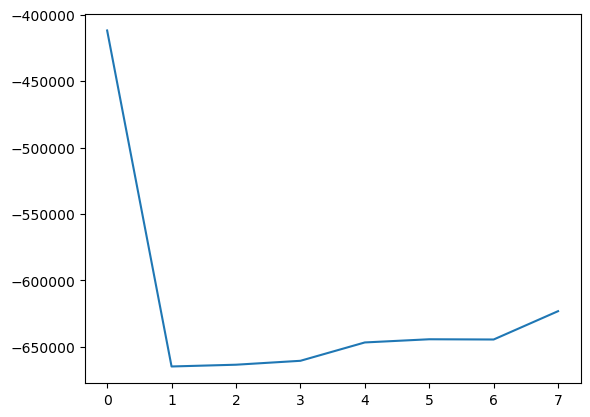

In [17]:
b_bics = []
for com in range(1, len(best_subsets)+1):
    w = np.linalg.lstsq(X_fft[:, best_subsets[com-1]], y_fft)[0]
    pred = X_fft[:, best_subsets[com-1]]@w
    b_bics.append(BIC_AIC(cal_PSD(pred), cal_PSD(y_fft), com)[0])
print(b_bics)
print(np.argmin(b_bics)+1)
plt.plot(b_bics); plt.show()

In [18]:
tau = 3
verbose = True
scale = np.log(len(y_fft))
# scale = 1 <- generalized UBIC
per = 75 # 75, 85, 95

post_means, _, b_uns = baye_uncertainties(best_subsets, (X_fft, y_fft), u_type='cv1', take_sqrt=True)
predictions = X_fft@post_means

b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    lower_bound = 2*np.abs(log_like_value(cal_PSD(predictions[:, k:k+1]), cal_PSD(y_fft)))-np.log(len(y_fft))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_fft), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_fft), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    if verbose:
        print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
              np.nan_to_num(imp, nan=np.inf))
    
    if (diff_com > 0 and (diff_bic > 0 or imp <= thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp >= thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 10)
    last_ubic = now_ubic
    last_bc = now_bc
    
last_lam = round(last_lam, 10)
last_lam, last_ubic, last_bc

threshold: 0.6144856560290807
max_lam: 4.786113986032334
1 <---> 1 inf
1 <---> 1 inf
1 <---> 1 inf


(0.0,
 array([-411595.51799724, -664774.95460838, -663409.08069794,
        -660443.79409433, -646599.26526188, -644204.3458156 ,
        -644327.16522059, -622992.46625495]),
 1)